# cheminfo tasks

In [1]:
from pathlib import Path
from maize.core.workflow import Workflow
from maize.core.node import Node
from maize.steps.io import LoadData, LogResult, Void, FileParameter, Return
from maize.steps.mai.molecule import LoadSmiles, LoadMolecule, Gypsum
from maize.core.interface import Input, Output
from maize.utilities.chem import IsomerCollection
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from pandas import DataFrame

```python
class Example(Node):
    out: Output[str] = Output()
    data: Parameter[str] = Parameter(default="hello")

    def run(self) -> None:
        self.out.send(self.data.value)
```

#### 記述子計算のWFを作ってみましょう
- CalcDescノードを定義します。これは入力としてSMILESのリストを受取りRDKITの記述子を計算します。

In [2]:
class CalcDesc(Node):
    out: Output[list[tuple]] = Output()
    inp: Input[list[str]] = Input()

    def run(self):
        res = []
        for smi in self.inp.receive():
            mol = Chem.MolFromSmiles(smi)
            if mol != None:
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                res.append((smi, mw, logp))
            else:
                res.append((smi, 'Invalid SMILES'))
        self.out.send(res)

flow1 = Workflow(name='infoexample1',cleanup_temp=True)
flow1.config.update(Path('../data/maize.toml'))

- 次いでワークフローを定義します。
- LoadData, Returnはどのようなものを受け取るか、返すかの方を定義してあげないとエラーになります。

In [3]:
load = flow1.add(LoadData[list[str]])
calc = flow1.add(CalcDesc)
res = flow1.add(Return[list[tuple]])
flow1.connect(load.out, calc.inp)
flow1.connect(calc.out, res.inp)

In [4]:
load.data.set(['CC', 'COC','c1cccccc1', 'c1cnccc1'])

In [5]:
flow1.check()

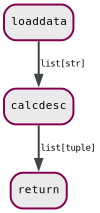

In [6]:
flow1.visualize()

In [7]:
flow1.execute()

2024-10-12 15:58:12,976 |     INFO |     infoexample1 | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-12 15:58:12,977 |     INFO |     infoexample1 | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-12 15:5

In [8]:
res.get()

[('CC', 30.07, 1.0262),
 ('COC', 46.069, 0.26260000000000006),
 ('c1cccccc1', 'Invalid SMILES'),
 ('c1cnccc1', 79.10199999999999, 1.0816)]

#### XTB calculation
- このコードを利用するためには同じ環境下に追加でXTBをインストールする必要があります
- [XTB](https://xtb-docs.readthedocs.io/en/latest/)は半経験的な量子科学計算のパッケージです。
- Maizeを利用することで入力部分の作成に労を割くことなく計算を実施できます。
- 
```bash
conda install -c conda-forge xtb
```

In [9]:
from maize.steps.mai.molecule.xtb import Xtb

class SetName(Node):
    inp: Input[list[IsomerCollection]] = Input()
    out: Output[list[IsomerCollection]] = Output()
    def run(self):
        res = []
        for i, iso in enumerate(self.inp.receive()):
            iso.set_tag('component', f'mol_{i}')
            res.append(iso)

        self.out.send(res)

In [10]:
flow2 = Workflow(name='xtb', cleanup_temp=True)
flow2.config.update(Path('../data/maize.toml'))

In [11]:
load = flow2.add(LoadData[list[str]])
emb = flow2.add(Gypsum)
setname = flow2.add(SetName)
qm = flow2.add(Xtb)
res = flow2.add(Return[list[IsomerCollection]])

In [18]:
# 入力はSMILESリストとしています
load.data.set(['c1ccccc1', 'c1cnccc1'])
# gypsumでのはいざ発生を１つにしています
emb.n_variants.set(1)
# xtbノードは内部で並列処理をするのですがデフォルトで100並列の設定になっておりそのまま実施すると100 coreない場合エラーになります。
qm.n_jobs.set(5)
# 計算結果を格納するフォルダを指定します。
qm.fold.set('./xtbres')

In [13]:
flow2.connect(load.out, emb.inp)
flow2.connect(emb.out, setname.inp)
flow2.connect(setname.out, qm.inp)
flow2.connect(qm.out, res.inp)
flow2.check()

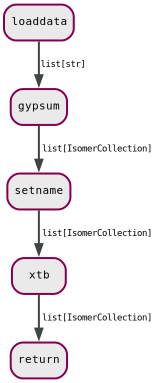

In [14]:
flow2.visualize()

In [15]:
flow2.execute()

2024-10-12 15:58:32,632 |     INFO |              xtb | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2024-10-12 15:58:32,634 |     INFO |              xtb | Starting Maize version 0.8.3 (c) AstraZeneca 2024
2024-10-12 15:5

In [16]:
mols = res.get()

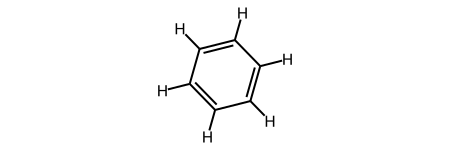

In [17]:
mols[0].molecules[0]._molecule